In [ ]:
This code enables to aggregate the Cropscape 30 reolsution maps in to 5-arcminute roelution by intersecting with overlayer MIRAD-US

In [24]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform, transform_bounds
from rasterio.mask import mask
from rasterio.windows import from_bounds
import geopandas as gpd
from shapely.geometry import box

# Paths
input_folder = "E:\\crop scape\\FInal Crop maps (30m)\\2015"  # Folder containing the input raster files
mirad_raster_path = "E:\\US Validation\\validation\\MirAD\\Map\\MirAD_2015.tif"  # Path to the MirAD-US raster
output_folder = 'E:\\crop scape\\Resampled\\Sugar beet'  # Folder to save the output rasters

# Function to reproject a raster to WGS84
def reproject_to_wgs84(input_path, output_path):
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest)

# Create necessary directories if they don't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
reprojected_folder = os.path.join(output_folder, 'Reprojected')
clipped_folder = os.path.join(output_folder, 'Clipped')
aggregated_folder = os.path.join(output_folder, 'Aggregated')

for folder in [reprojected_folder, clipped_folder, aggregated_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

# Process each input file
for input_file in os.listdir(input_folder):
    if input_file.endswith(".tif"):
        input_path = os.path.join(input_folder, input_file)
        
        base_name = os.path.splitext(input_file)[0]
        reprojected_crop_raster_path = os.path.join(reprojected_folder, f'reprojected_{base_name}.tif')
        reprojected_mirad_raster_path = os.path.join(reprojected_folder, 'reprojected_mirad_layer_wgs84.tif')
        clipped_mirad_path = os.path.join(clipped_folder, f'clipped_mirad_{base_name}.tif')
        output_raster_path = os.path.join(aggregated_folder, f'{base_name}.tif')
        
        # Reproject the CropScape raster to WGS84
        reproject_to_wgs84(input_path, reprojected_crop_raster_path)
        
        # Reproject the MirAD-US raster to WGS84 only once
        if not os.path.exists(reprojected_mirad_raster_path):
            reproject_to_wgs84(mirad_raster_path, reprojected_mirad_raster_path)

        print(f"Reprojected {input_file} to WGS84 successfully.")
        
        # Clip the MirAD-US map based on the extent of the reprojected crop raster
        with rasterio.open(reprojected_crop_raster_path) as src:
            crop_bounds = src.bounds
            crop_extent = [box(*crop_bounds)]

        with rasterio.open(reprojected_mirad_raster_path) as src:
            out_image, out_transform = mask(src, crop_extent, crop=True)
            out_meta = src.meta.copy()
            out_meta.update({
                "driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
                "transform": out_transform,
                "crs": 'EPSG:4326'
            })

            with rasterio.open(clipped_mirad_path, "w", **out_meta) as dest:
                dest.write(out_image)

        print(f"MirAD-US map clipped for {input_file} successfully.")
        
        # Aggregate the 30m raster based on the 5 arcminute grid cells of the MirAD-US map
        with rasterio.open(clipped_mirad_path) as mirad_src, rasterio.open(reprojected_crop_raster_path) as crop_src:
            mirad_data = mirad_src.read(1)
            mirad_transform = mirad_src.transform
            mirad_bounds = mirad_src.bounds
            crop_transform = crop_src.transform
            aggregated_data = np.zeros(mirad_data.shape, dtype='float32')

            for i in range(mirad_data.shape[0]):
                for j in range(mirad_data.shape[1]):
                    if mirad_data[i, j] > 0:  # Only process cells with MirAD-US values > 0
                        cell_bounds = rasterio.windows.bounds(((i, i + 1), (j, j + 1)), transform=mirad_transform)
                        window = from_bounds(*cell_bounds, transform=crop_transform)
                        window_data = crop_src.read(1, window=window, boundless=True)
                        count = np.sum(window_data == 41)  # Count Corn pixels (value 1)
                        aggregated_data[i, j] = count * 0.09  # Convert to hectares

        print(f"Corn data aggregated for {input_file} successfully.")
        
        # Save the aggregated data
        output_transform = mirad_transform

        # Create the metadata for the output file
        out_meta = mirad_src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": aggregated_data.shape[0],
            "width": aggregated_data.shape[1],
            "transform": output_transform,
            "crs": 'EPSG:4326',
            "dtype": 'float32',
            "nodata": 0
        })

        with rasterio.open(output_raster_path, 'w', **out_meta) as dst:
            dst.write(aggregated_data, 1)

        print(f"Aggregated data saved for {input_file} successfully.")


Reprojected 1.tif to WGS84 successfully.
MirAD-US map clipped for 1.tif successfully.
Corn data aggregated for 1.tif successfully.
Aggregated data saved for 1.tif successfully.
Reprojected 10.tif to WGS84 successfully.
MirAD-US map clipped for 10.tif successfully.
Corn data aggregated for 10.tif successfully.
Aggregated data saved for 10.tif successfully.
Reprojected 11.tif to WGS84 successfully.
MirAD-US map clipped for 11.tif successfully.
Corn data aggregated for 11.tif successfully.
Aggregated data saved for 11.tif successfully.
Reprojected 12.tif to WGS84 successfully.
MirAD-US map clipped for 12.tif successfully.
Corn data aggregated for 12.tif successfully.
Aggregated data saved for 12.tif successfully.
Reprojected 13.tif to WGS84 successfully.
MirAD-US map clipped for 13.tif successfully.
Corn data aggregated for 13.tif successfully.
Aggregated data saved for 13.tif successfully.
Reprojected 14.tif to WGS84 successfully.
MirAD-US map clipped for 14.tif successfully.
Corn data a

In [12]:
import os
import glob
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.plot import show

def mosaic_rasters(input_folder, output_file):
    # Find all the raster files in the input folder
    raster_files = glob.glob(os.path.join(input_folder, "*.tif"))
    
    # Read all the raster files
    src_files_to_mosaic = []
    for fp in raster_files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)
    
    # Perform the merge, taking the maximum value where there is overlap
    mosaic, out_trans = merge(src_files_to_mosaic, method="max")
    
    # Copy the metadata of the first file to use as a template
    out_meta = src_files_to_mosaic[0].meta.copy()
    
    # Update the metadata to reflect the number of layers, width, height, and transformation of the mosaic
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": 1
    })
    
    # Write the mosaic raster to disk
    with rasterio.open(output_file, "w", **out_meta) as dest:
        dest.write(mosaic[0], 1)
    
    # Close all the source files
    for src in src_files_to_mosaic:
        src.close()

# Example usage
input_folder ="E:\\crop scape\\Resampled\\Wheat\\Aggregated\\Winter"
output_file = "E:\\crop scape\\Resampled\\Wheat\\Aggregated\\Wheat3.tif"
# output_file = "E:\\US Validation\\2015\Final\\Soybeans.tif"
mosaic_rasters(input_folder, output_file)


C:\Users\endal\AppData\Local\Temp\ipykernel_87696\3099237347.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_87696\3099237347.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_87696\3099237347.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_87696\3099237347.py:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
C:\Users\endal\AppData\Local\Temp\ipykernel_87696\3099237347.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.s

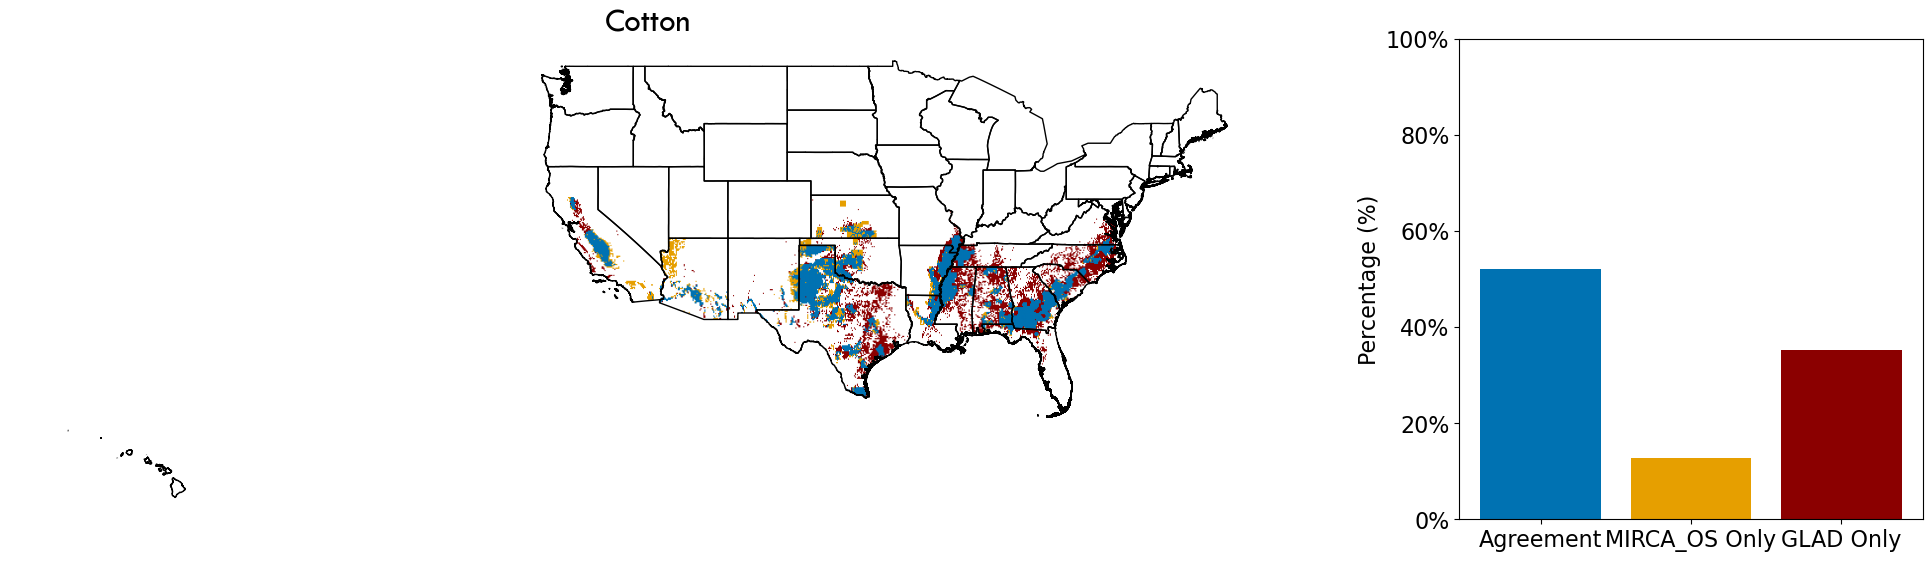

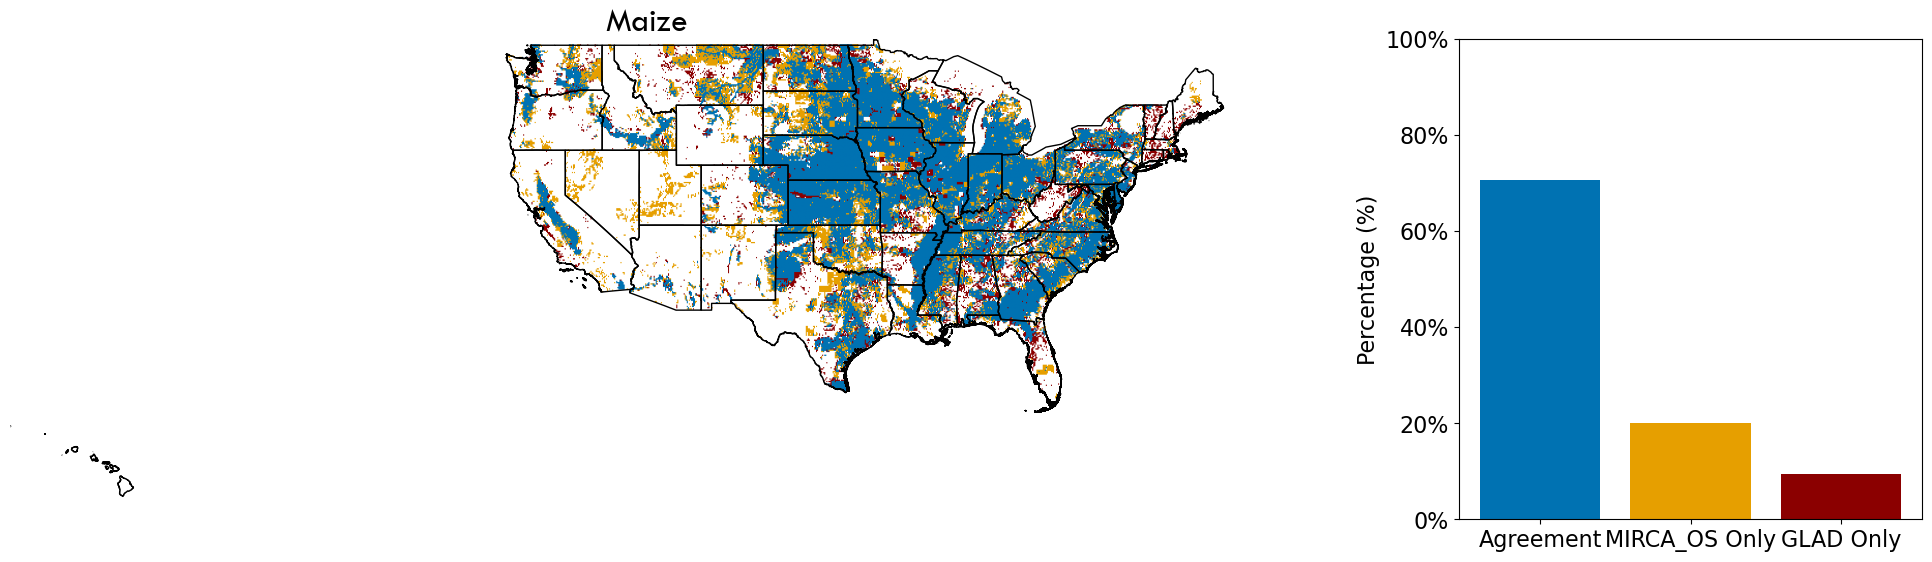

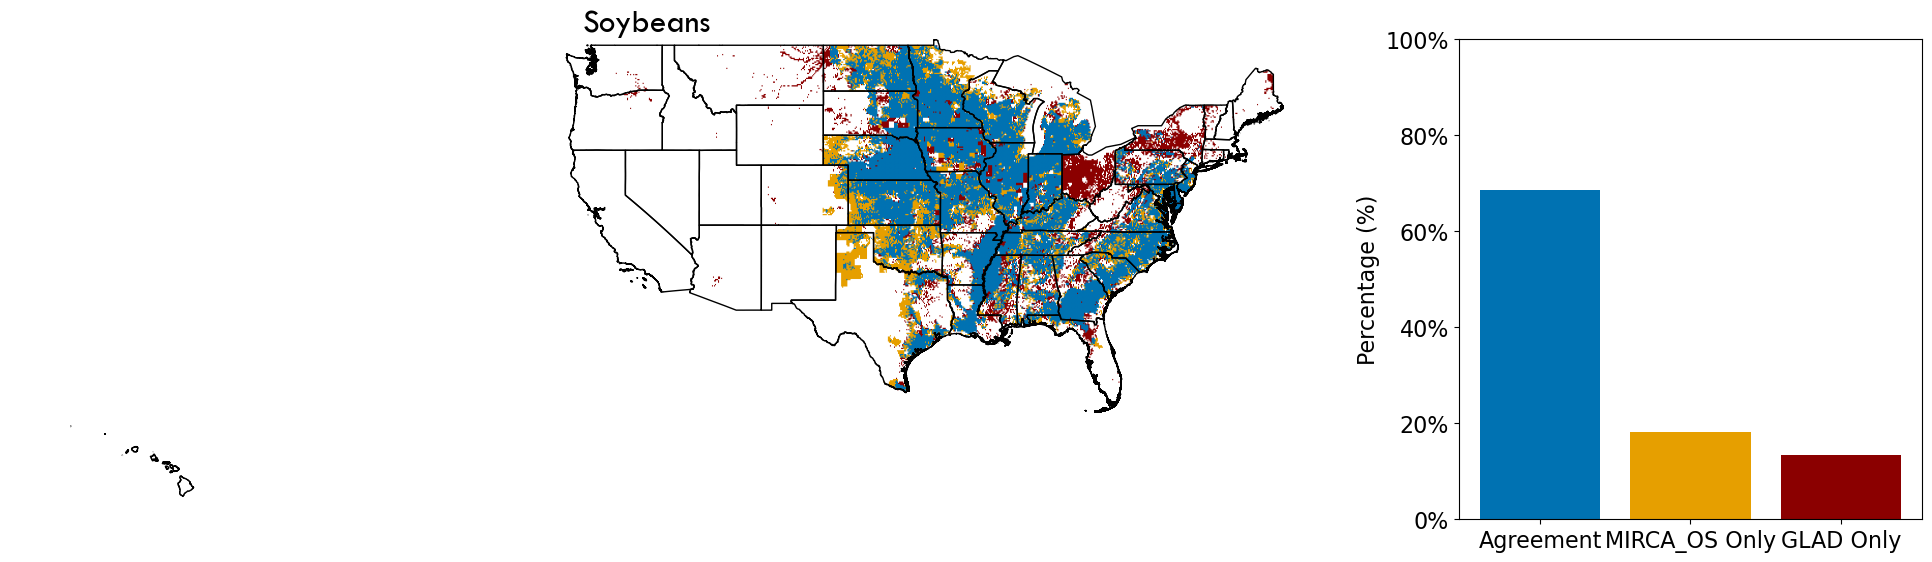

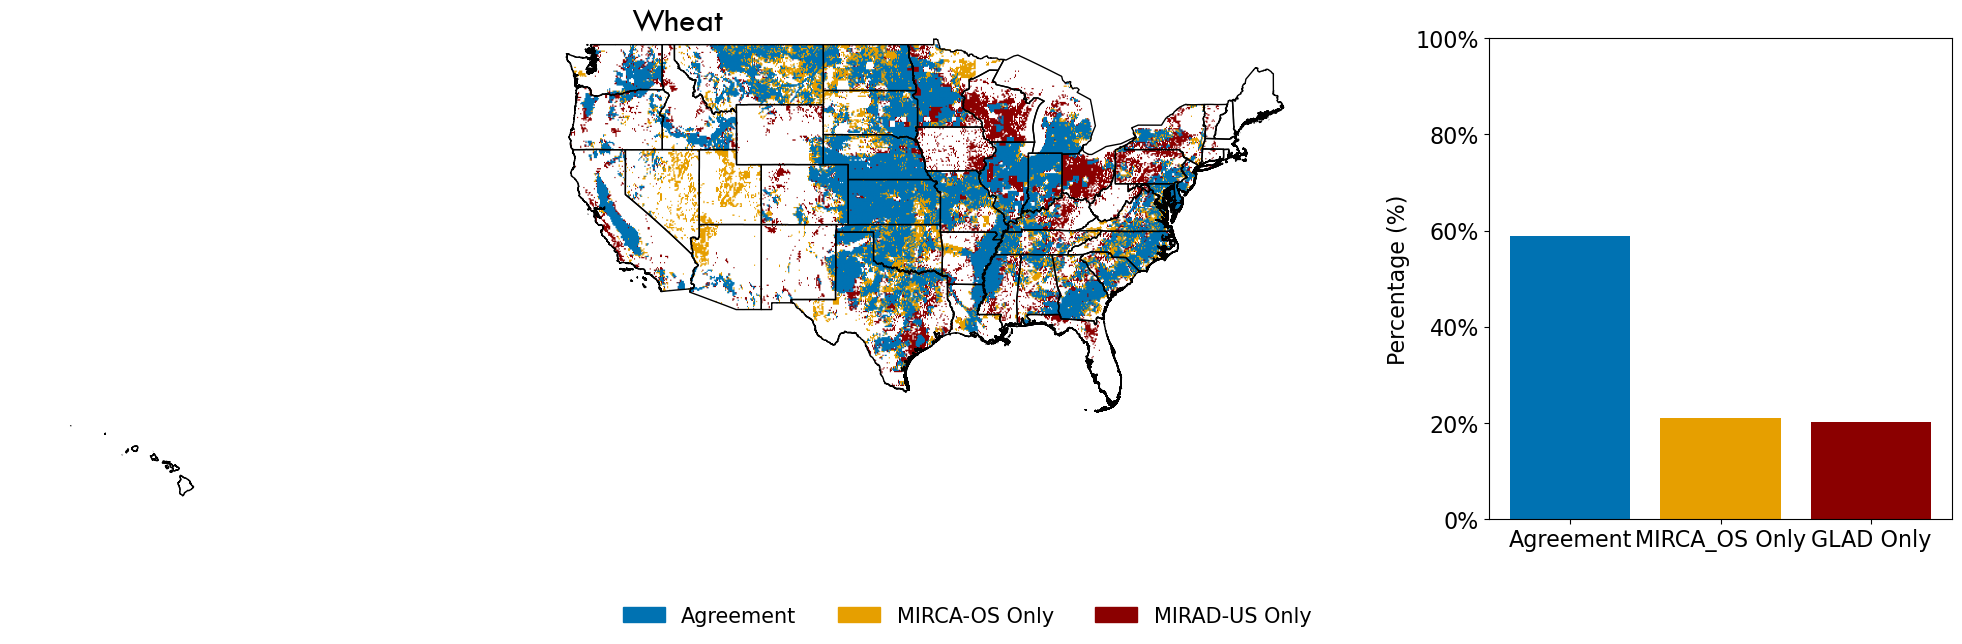

In [4]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.warp import reproject, Resampling

# Define colorblind-friendly colors for the plot
dark_blue = '#0072B2'  # Dark Blue for agreement
orange = '#E69F00'  # Orange for MIRCA-OS Only
dark_red = '#8B0000'  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Function to reproject and resample raster data to match another raster
def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
def clean_raster_data(raster_data, extreme_value_threshold=0):
    cleaned_data = np.where(raster_data < extreme_value_threshold, np.nan, raster_data)
    return cleaned_data

# Function to calculate agreement percentages for the bar chart
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_only_pct

# Function to calculate IoU
def calculate_iou(agree, mirca_os_only, mirca_2000_only):
    intersection = np.sum(agree)
    union = intersection + np.sum(mirca_os_only) + np.sum(mirca_2000_only)
    iou = intersection / union if union > 0 else 0
    return iou

# Load the shapefile and reproject it to WGS84
shapefile_path = "D:\\PhD_Udel\\MICRA_2015\\DOwnscaling\\North America\\shapefile\\gadm41_USA_1.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs(epsg=4326)

# Directories for raster data
base_dir_os = "E:\\US Validation\\2015\\MIRCA-OS New"
base_dir_2000 = "E:\\US Validation\\2015\\Final"

# Crop names
crops = ["Cotton", "Maize", "Soybeans", "Wheat"]

# Set up the plot dimensions and resolution
figsize = (20, 6)  # Adjusted to include space for the bar chart
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [3, 1]})
    
    # Read rasters
    raster1, transform1, crs1 = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2, transform2, crs2 = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Reproject rasters to WGS84
    if crs1 != 'EPSG:4326':
        raster1, transform1 = reproject_and_resample(raster1, transform1, crs1, raster1.shape, transform1, 'EPSG:4326')
    if crs2 != 'EPSG:4326':
        raster2, transform2 = reproject_and_resample(raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326')

    # Ensure raster2 has the same dimensions as raster1
    raster2_resampled, _ = reproject_and_resample(
        raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326'
    )

    # Clean rasters
    raster1 = clean_raster_data(raster1)
    raster2_resampled = clean_raster_data(raster2_resampled)
    raster1 = np.maximum(raster1, 0)
    raster2_resampled = np.maximum(raster2_resampled, 0)
    
    # Compare rasters
    agree = (raster1 >= 0) & (raster2_resampled >= 0)
    mirca_os_only = (raster1 > 0) & ((raster2_resampled == 0) | np.isnan(raster2_resampled))
    mirca_2000_only = (raster2_resampled > 0) & ((raster1 == 0) | np.isnan(raster1))

    # Initialize combined RGB array with white background
    combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = np.array([0, 114, 178]) / 255  # Dark Blue for agreement
    combined_rgb[mirca_os_only] = np.array([230, 159, 0]) / 255  # Orange for MIRCA-OS Only
    combined_rgb[mirca_2000_only] = np.array([139, 0, 0]) / 255  # Dark Red for MIRCA2000 Only

    # Plot map
    extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Calculate IoU score
    iou = calculate_iou(agree, mirca_os_only, mirca_2000_only)

    # Plot bar chart on ax_bar
    labels = ['Agreement', 'MIRCA_OS Only', 'GLAD Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
    ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
    ax_bar.set_ylabel('Percentage (%)', fontsize=16)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=16)
    ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)

    # Display IoU score on the bar chart
#     ax_bar.text(1.5, 105, f'IoU: {iou:.2f}', ha='center', va='center', fontsize=20, fontname=title_font, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

    # Legend
    if i == len(crops) - 1:
        legend_elements = [
            mpatches.Patch(color=dark_blue, label='Agreement'),
            mpatches.Patch(color=orange, label='MIRCA-OS Only'),
            mpatches.Patch(color=dark_red, label='MIRAD-US Only')
        ]
        # Place the legend below the last map, centered
        plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=15, frameon=False, bbox_to_anchor=(0.5, -0.1))
#     if i == len(crops) - 1:
#         legend_elements = [
#             mpatches.Patch(color=dark_blue, label='Agreement'),
#             mpatches.Patch(color=orange, label='MIRCA-OS Only'),
#             mpatches.Patch(color=dark_red, label='GLAD Only')
#         ]
#         plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=16, frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter to fit your plot and legend inside the figure
#     plt.savefig(f'E:\\US Validation\\Final Maps\\{crop}_2015.png', bbox_inches='tight')

plt.show()


Crop: Cotton, Number of valid data points: 6152
Crop: Maize, Number of valid data points: 39686
Crop: Soybeans, Number of valid data points: 29067
Crop: Wheat, Number of valid data points: 37194


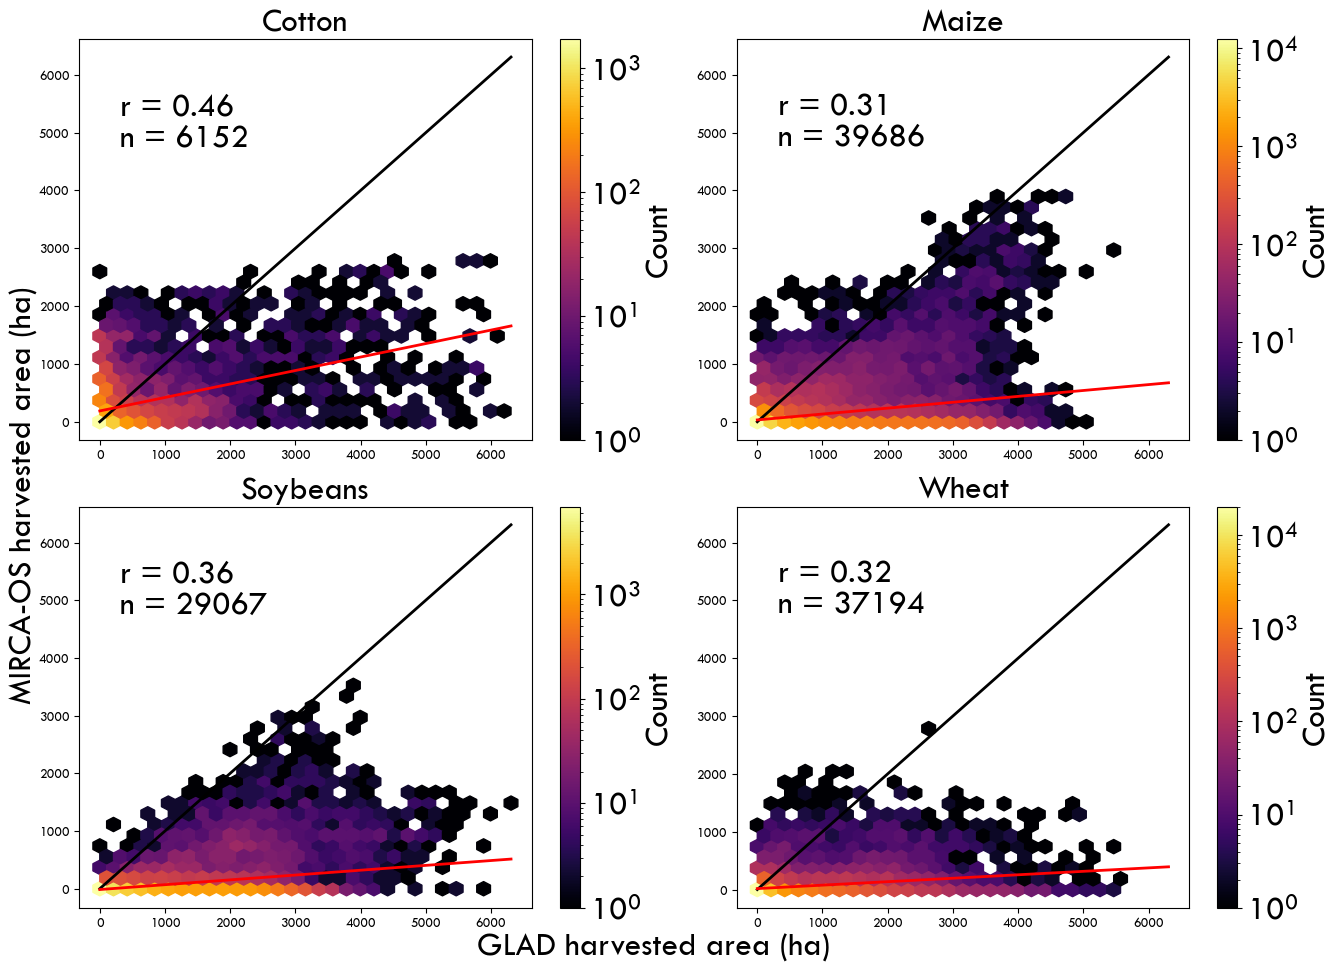

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data, nan_value):
    """
    Replace the given NaN value in raster data with actual NaNs and zero for negative values.
    """
    raster_data = np.where(raster_data == nan_value, np.nan, raster_data)
    return np.where((raster_data < 0), np.nan, raster_data)

# Define the plot_scatter_and_regression function
def plot_scatter_and_regression(ax, x, y, crop_name, n_valid, common_min, common_max):
    x = x
    y = y
    
    # Calculate the Pearson correlation coefficient
    r, _ = pearsonr(x, y)

    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot
    text_x = common_min + (common_max - common_min) * 0.05
    text_y = common_max - (common_max - common_min) * 0.1
    ax.text(text_x, text_y, f'r = {r:.2f}\nn = {n_valid}', color='black', ha='left', va='top', backgroundcolor='white', fontsize=font_size)

    # Set title
    ax.set_title(f'{crop_name}', fontsize=font_size)

# Define the paths to the directories
# folder1 = "E:\\Brazil Validation\\MIRCA-OS_GAEZ"
# folder2 =  "E:\\Brazil Validation\\Total Soy\\MIRCA-OS"
folder2 = "E:\\US Validation\\Global clipped\\Global\\2015_clipped"
folder1 = "E:\\US Validation\\2015\\Final"


# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Define the NaN value
nan_value = 0

# Determine the maximum dimensions for resampling
max_height = 0
max_width = 0
for raster_path in list(rasters1.values()) + list(rasters2.values()):
    with rasterio.open(raster_path) as src:
        max_height = max(max_height, src.height)
        max_width = max(max_width, src.width)

# Initialize variables to find the common min and max values
common_min_x = float('inf')
common_max_x = float('-inf')
common_min_y = float('inf')
common_max_y = float('-inf')

# Function to resample raster to match the maximum dimensions
def resample_raster(src, max_height, max_width):
    data = src.read(
        out_shape=(
            src.count,
            max_height,
            max_width
        ),
        resampling=Resampling.bilinear
    )
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    return data[0], transform

# Iterate over the rasters to determine the common axis limits
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)
            
            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Update common min and max values
            common_min_x = min(common_min_x, np.nanmin(data1))
            common_max_x = max(common_max_x, np.nanmax(data1))
            common_min_y = min(common_min_y, np.nanmin(data2))
            common_max_y = max(common_max_y, np.nanmax(data2))

common_min = min(common_min_x, common_min_y)
common_max = max(common_max_x, common_max_y)

# Iterate over the rasters again to plot the data
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)

            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Calculate the number of valid data points for this crop
            n_valid = len(data1)
            print(f'Crop: {crop_name}, Number of valid data points: {n_valid}')  # Debugging statement

            # Find the next available subplot
            ax = next((ax for ax in axs if not hasattr(ax, 'data_plotted')), None)
            if ax is None:
                print("No more empty subplots available.")
                break

            # Plot the data on the corresponding subplot axis
            plot_scatter_and_regression(ax, data1, data2, crop_name, n_valid, common_min, common_max)
            
            # Mark this axis as having data plotted on it
            ax.data_plotted = True

# Set common x and y labels
fig.text(0.5, 0.04, 'GLAD harvested area (ha)', ha='center', fontsize=font_size)
fig.text(0.04, 0.5, 'MIRCA-OS harvested area (ha)', va='center', rotation='vertical', fontsize=font_size)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust rect to fit common labels
# plt.savefig('E:\\US Validation\\Final Maps\\Scatter.png', bbox_inches='tight')
plt.show()
